In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import math
from tqdm.auto import tqdm

# Turning off the warning message
pd.set_option('mode.chained_assignment', None)

### Loading S&P500 levels and dividends data
I will be learning the PCA matrix with one year of data, and apply the algorithm on six months of data after the calibration period.

In [18]:
df_snp500 = pd.read_csv(os.path.join('/Users/skim/Desktop/Code/Quant/data/kospi200.csv'))
df_snp500 = df_snp500[['Date','Symbol','Close']]
start_date = '2020-01-01'
end_date = '2021-06-31'
df_snp500 = df_snp500.loc[(df_snp500.Date > start_date) & (df_snp500.Date < end_date)]
df_snp500_wide = df_snp500.pivot(index='Date', columns='Symbol', values='Close')
print(f'There are {sum(df_snp500_wide.isna().sum() > 0)} stocks with missing data')

There are 8 stocks with missing data


In [19]:
df_dividends = pd.read_csv(os.path.join('/Users/skim/Desktop/Code/Quant/data/kospi200_dividends.csv'))
df_dividends = df_dividends.loc[(df_dividends.Date > '2020-01-01') & (df_dividends.Date < '2021-06-31')]
df_dividends.set_index(df_dividends.Date, inplace = True)
df_dividends.drop(columns = ['Date'], inplace = True)
df_dividends = df_dividends.loc[:, list(df_snp500_wide.columns)]

In [4]:
df_snp500 = pd.read_csv(os.path.join('/Users/skim/Desktop/Code/Quant/data/snp500.csv'))
df_snp500 = df_snp500[['Date','Symbol','Close']]
start_date = '2020-01-01'
end_date = '2022-16-31'
df_snp500 = df_snp500.loc[(df_snp500.Date > start_date) & (df_snp500.Date < end_date)]
df_snp500_wide = df_snp500.pivot(index='Date', columns='Symbol', values='Close')
print(f'There are {sum(df_snp500_wide.isna().sum() > 0)} stocks with missing data')

There are 5 stocks with missing data


In [5]:
df_dividends = pd.read_csv(os.path.join('/Users/skim/Desktop/Code/Quant/data/snp500_dividends.csv'))
df_dividends = df_dividends.loc[(df_dividends.Date > '2020-01-01') & (df_dividends.Date < '2022-12-31')]
df_dividends.set_index(df_dividends.Date, inplace = True)
df_dividends.drop(columns = ['Date'], inplace = True)
df_dividends = df_dividends.loc[:, list(df_snp500_wide.columns)]

In [21]:
# Remove columns(stocks) with NAs
df_snp500_wide = df_snp500_wide.loc[:,(df_snp500_wide.isna().sum() == 0).values]
print(f'There are {df_snp500_wide.shape[1]} stocks with no missing data')

There are 183 stocks with no missing data


In [22]:
df_data = df_snp500_wide

In [23]:
def compute_return(data):
    '''
    Computes daily returns for each column(stock).
    '''
    df_return = (data-data.shift(1))/data
    df_return = df_return.drop(df_return.index[0])
    return df_return


def PCA_fator(df_return, delay, fac_num):
    '''
    Returns eigenvectors and eigenportfolio weights.
    
    ## Notations ## 
    N: Number of stocks
    T: Length of dataframe
    W: delay = 252
    P: Number of PCA factors
    
    ## Variables ##
    df_return: ((T-1) x N) dataframe of daily returns
    delay: Number of days used for PCA computation
    fac_num: number of PCA factors
    '''
    mean = df_return.mean(axis = 0) # (N x 1), Mean return of stocks
    std = df_return.std(axis = 0) # (N x 1), Sample standard deviation of stock returns
    std_ret = (df_return-mean)/std # (N x 1), Standardised return
    
    pca = PCA(n_components = fac_num)
    pca.fit(std_ret[0:delay]) # Fit PCA with first T observations
    pf_weight = pd.DataFrame(pca.components_) # (P x N), P eigenvectors(rows) of length N
    pf_weight.columns = std.index
    pf_weight = pf_weight/std # Each row is an eigenvector/sample standard deviation for factor j, representing eigenportfolio weights for stocks
    factor_ret = pd.DataFrame(df_return@pf_weight.transpose(), index = df_return.index) # (T x P), Eigenportfolio returns
    return factor_ret, pf_weight

For stock $i$, we fit below PCR regression, and obtain coefficients and residual process.
$$ \epsilon_{i,t} = \text{stock return}_{i,t} - \hat{\text{stock return}_{t, p}}$$
$$ = \text{stock return}_{i,t} - (\alpha + \sum_{p=1}^{P} \beta_{p,i} * \text{eigenportfolio return}_{t, p})$$

In [24]:
def find_Residue(df_return, ret_factorret):
    '''
    Returns OLS coefficients of residual process
    
    ## Notations ## 
    N: Number of stocks
    w: backtesting window = 60
    P: Number of PCA factors
    
    ## Variables ##
    df_return: ((w-1) x N), dataframe of daily returns
    ret_factorret: ((w-1) x N), eigenportfolio returns
    res: ((w-1) x N), 
    coef: (P x N), each column contains OLS coefficients for PCA factor regression
    '''
    T, P = ret_factorret.shape
    res = pd.DataFrame(columns = df_return.columns, index = df_return.index)
    coef = pd.DataFrame(columns = df_return.columns, index = range(P)) 
    ols = LinearRegression()
    for i in df_return.columns: 
        ols.fit(ret_factorret, df_return[i]) # fit (w x P) eigenportfolio returns data to (w x 1) stock i returns data.
        res[i] = df_return[i] - ols.intercept_ - np.dot(ret_factorret, ols.coef_) # Each column of res is the daily residual
        coef[i] = ols.coef_
    return res, coef

We select stocks with mean-reversion times less than 1/2 period, i.e. $\kappa > \frac{252}{30} = 8.4$, and the s-score is for stock i is given by $$ s_i = \frac{\epsilon_i(t)-m_i}{\sigma_{\text{eq,i}}} $$
where $m_i$ is sample mean of cumulative residuals, and $\sigma_{\text{eq,i}} = \frac{\sigma_i}{\sqrt{2 \kappa_i}}$

In [25]:
def find_Target_sscores(res, k):
    '''
    Compute trading signal, s-score.
    
    ## Notations ## 
    N: Number of stocks
    w: backtesting window = 60
    P: Number of PCA factors
    
    ## Variables ##
    df_return: ((w-1) x N), dataframe of daily returns
    ret_factorret: ((w-1) x N), eigenportfolio returns
    res: ((w-1) x N), 
    coef: (P x N), each column contains OLS coefficients for PCA factor regression
    s_score: (N x 1), s-score for each stock 
    '''
    cum_res = res.cumsum() # ((w-1) x N) df of cumulative residuals
    m = pd.Series(index = cum_res.columns, dtype = 'float64') # (N x 1), mean 
    sigma_eq = pd.Series(index = cum_res.columns, dtype = 'float64') # (N x 1) series
    for i in cum_res.columns: # For each stock 
        b = cum_res[i].autocorr() # A scalar of autocorrelation of first lag 
        if -math.log(b) * 252 > k: 
            '''
            The higher the first order autocorr, the lower the value of -math.log(b) * 252.
            This is a measure of mean-reversion time, and we choose stock i with mean-reversion times less than 0.5 period(30 days),
            i.e. k = 252/30 = 8.4
            '''
            temp = (cum_res[i]-cum_res[i].shift(1) * b)[1:] # AR(1) prediction residuals of cumulative residuals = Current cumulative residual - (b * previous cumulative residual)
            a = temp.mean()
            cosi = temp - a
            m[i] = a/(1-b)
            sigma_eq[i] = math.sqrt(cosi.var()/(1-b*b))
    m = m.dropna()
    m = m - m.mean()
    sigma_eq = sigma_eq.dropna()
    s_score = -m / sigma_eq
    return s_score

In [66]:
def backtest():
    '''
    ## Notations ## 
    N: Number of stocks
    T: Length of dataframe
    W: delay
    P: Number of PCA factors
    '''
    pnl_list = []
    sbo = 2 # buy to open threshold
    sso = 2 # sell to open
    sbc = 0.75 # buy to close
    ssc = 0.5 # sell to close
    leverage = 1
    tran_cost = 0.0005
    r = 0.00
    window = 60
    k = 8.4
    P = 15

    delay = 252
    start_val = 100
    pnl = pd.Series(start_val, index = df_data.index[delay-1:]) # pnl for OOS backtesting
    
    position_stock = pd.DataFrame(0, columns = df_data.columns, index = ['stock'] + list(range(15))) # ((P+1) x N) df
    position_stock_before = pd.Series(0, index = df_data.columns) # (N x 1) series
    
    daily_ret = compute_return(df_data)
    fac_ret, weights = PCA_fator(daily_ret, delay, P)

    # (W-1) to T-1
    for t in tqdm(range(delay-1, len(df_data.index)-1)):
    # find the window price of all stocks
        price_t = df_snp500_wide[(t-window):(t+1)]
        ret_t = compute_return(price_t)
        # Only pick corresponding w days window data from ((T x P) eigenportfolio df)
        fac_ret_t = fac_ret[(t-window+1):(t+1)]
        res_t, coef_t = find_Residue(ret_t, fac_ret_t)
        target = find_Target_sscores(res_t, k)

        for i in position_stock.columns:
            if not i in target.index: # If i is dropped during find target s-score process, i.e. the mean reversion time was too long,
                if position_stock[i]['stock'] != 0: # If the current position is non-zero
                    position_stock[i] = 0 # clear the position
            else: # if mean reversion time was short enough,
                if position_stock[i]['stock'] == 0: # if the current position is zero
                    if target[i] < -sbo: # if the current signal is lower than the buy to open threshold
                        position_stock[i]['stock'] = leverage # i.e. set the stock row as 1, indicating we have a position in the stock
                        position_stock[i][1:] = -leverage * coef_t[i] 
                    elif target[i] >sso:
                        position_stock[i]['stock'] = - leverage
                        position_stock[i][1:] = leverage * coef_t[i]
                elif position_stock[i][0] > 0 and target[i] > -ssc: # If the current position is positive, and we have a sell to close signal
                    position_stock[i] = 0
                elif position_stock[i][0] < 0 and target[i] < sbc: # If the current position is negative, and we have a buy to close signal
                    position_stock[i] = 0
            dps_t = df_dividends.iloc[t+1]
            pri_t = df_snp500_wide.iloc[t+1]
            temp = (dps_t/pri_t).fillna(0)
            position_stock_temp = pd.Series(0,index = df_snp500_wide.columns)
            fac_sum = position_stock.sum(axis = 1)[1:]
            for i in weights.columns:
                position_stock_temp = sum(weights[i] * fac_sum)
            position_stock_temp = position_stock_temp + position_stock.iloc[0]
            change = sum(abs(position_stock_temp - position_stock_before))
            position_stock_before = position_stock_temp
            pnl.iloc[t-delay + 2] = pnl.iloc[t-delay + 1] * ( 1 + r /252.0) + np.dot(position_stock.loc['stock'], daily_ret.iloc[t]) + np.dot(position_stock.sum(axis = 1)[1:], fac_ret.iloc[t]) - position_stock.sum().sum() * r /252.0 - change * tran_cost
        print (f'Portfolio value on day {t}: {pnl.iloc[t-delay + 2]}')
        pnl_list.append(pnl.iloc[t-delay + 2])
    return pnl_list

In [51]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

In [46]:
start = datetime.datetime(2021 ,1 ,8)
end = datetime.datetime(2021, 6, 30)

In [48]:
df = yf.download('^KS11', start = start, end = end, period='1d')

[*********************100%***********************]  1 of 1 completed


In [73]:
kospi_ret = compute_return(df.Close)

In [110]:
pd.DataFrame(kospi_ret).index

DatetimeIndex(['2021-01-11 00:00:00+09:00', '2021-01-12 00:00:00+09:00',
               '2021-01-13 00:00:00+09:00', '2021-01-14 00:00:00+09:00',
               '2021-01-15 00:00:00+09:00', '2021-01-18 00:00:00+09:00',
               '2021-01-19 00:00:00+09:00', '2021-01-20 00:00:00+09:00',
               '2021-01-21 00:00:00+09:00', '2021-01-22 00:00:00+09:00',
               ...
               '2021-06-16 00:00:00+09:00', '2021-06-17 00:00:00+09:00',
               '2021-06-18 00:00:00+09:00', '2021-06-21 00:00:00+09:00',
               '2021-06-22 00:00:00+09:00', '2021-06-23 00:00:00+09:00',
               '2021-06-24 00:00:00+09:00', '2021-06-25 00:00:00+09:00',
               '2021-06-28 00:00:00+09:00', '2021-06-29 00:00:00+09:00'],
              dtype='datetime64[ns, Asia/Seoul]', name='Date', length=117, freq=None)

In [117]:
return_lst = [100]
for i in range(len(kospi_ret)):
    return_lst.append(return_lst[-1] + return_lst[-1] * kospi_ret[i])

In [127]:
return_lst.pop()

102.84925267746267

In [128]:
len(pd.DataFrame(kospi_ret).index)

117

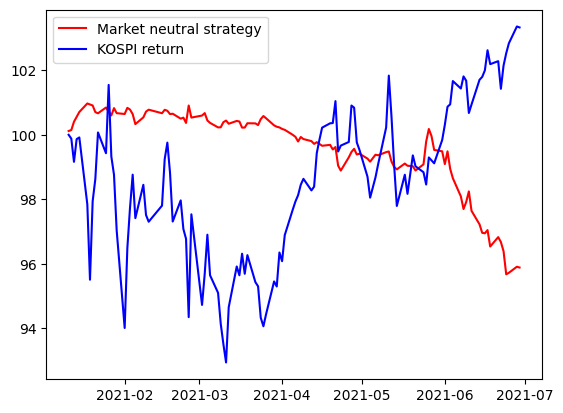

In [129]:
plt.plot(pd.DataFrame(kospi_ret).index, pnl_output, '-r', label = 'Market neutral strategy')
plt.plot(pd.DataFrame(kospi_ret).index, return_lst, '-b', label = 'KOSPI return')
plt.legend()
plt.show()

In [67]:
pnl_output = backtest()

  0%|          | 0/119 [00:00<?, ?it/s]

Portfolio value on day 251: 100.11766175923283
Portfolio value on day 252: 100.14671756242113
Portfolio value on day 253: 100.40479297607818
Portfolio value on day 254: 100.554664559422
Portfolio value on day 255: 100.7065273671288
Portfolio value on day 256: 100.9710541252818
Portfolio value on day 257: 100.9395579230747
Portfolio value on day 258: 100.90844395453723
Portfolio value on day 259: 100.7026808850847
Portfolio value on day 260: 100.66588929949852
Portfolio value on day 261: 100.84553979737935
Portfolio value on day 262: 100.71587770738161
Portfolio value on day 263: 100.6001940069799
Portfolio value on day 264: 100.82667495364053
Portfolio value on day 265: 100.67099448958243
Portfolio value on day 266: 100.64426915797759
Portfolio value on day 267: 100.835397997538
Portfolio value on day 268: 100.78188847207015
Portfolio value on day 269: 100.64110155576728
Portfolio value on day 270: 100.33022197675115
Portfolio value on day 271: 100.53984117191794
Portfolio value on day